In [331]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [332]:
torch.cuda.is_available()

True

In [333]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [479]:
# Load data from text file
Status = np.loadtxt("Status_2024_05_31_causal_2.txt", dtype=int)  # Specify dtype if known, for efficiency
Target = np.loadtxt("Target_2024_05_31_causal_2.txt", dtype=float).T

num_training_data=10000

N=Status.shape[0]

Target_train=torch.tensor(Target[30000:30000+num_training_data,:]).float()
Target_test=torch.tensor(Target[30000:40000,:]).float()
Target_val=torch.tensor(Target[40000:50000,:]).float()
print(Target_train.shape,Target_test.shape,Target_val.shape)


torch.Size([10000, 10]) torch.Size([10000, 10]) torch.Size([10000, 10])


Notice that:
1. Each row of above X matrice is the vector of status of node 1 to node T
2. Each row of above Y is the status of node T+1

Then we need to construct word embedding and positional encoding

$$\tilde{X}^T=\begin{bmatrix}
    e_{s_1}& e_{s_2}&\cdots&e_{s_T}\\
    e_1&e_2&\cdots&e_T
\end{bmatrix}=\begin{bmatrix}
    \mathcal{E}_{s_{1:T}}\\
    \mathbb{I}_{T}
\end{bmatrix}$$

Generate $\mathbb{I}_{T}$ and $\mathcal{E}_{s_{1:T}}$

The input of Transformer should be $\tilde{X}^T$ and the output is $\pi(s'|s_T)$

#### Construct the input

In [480]:
S=10
T=20

#number of random sequence


I_S=np.identity(S)
I_t=np.identity(T)

#(iter,S+T,T)
X_tilde_T=np.empty((N,S+T,T))


for i in range(N):

    epsilon_1_T=np.zeros((S,T))

    #print(T)

    for k in range(T):
        epsilon_1_T[:,int(k)]=I_S[:,int(Status[i,int(k)])]

    #print(Status[0])

    X_tilde_T[i]=np.concatenate((epsilon_1_T,I_t),axis=0)


X_tilde=X_tilde_T.transpose(0,2,1)



X_train_tilde=torch.tensor(X_tilde[30000:30000+num_training_data])
X_test_tilde=torch.tensor(X_tilde[30000:40000])
X_val_tilde=torch.tensor(X_tilde[40000:50000])

X_train_tilde.to(device)
X_test_tilde.to(device)
X_val_tilde.to(device)

print(X_train_tilde.shape)
print(X_test_tilde.shape)

torch.Size([10000, 20, 30])
torch.Size([10000, 20, 30])


In [481]:
batch_size=100

train_dataset=TensorDataset(torch.tensor(X_train_tilde).float(),torch.tensor(Target_train).float())
train_data=DataLoader(train_dataset,batch_size=batch_size)

# test_dataset=TensorDataset(torch.tensor(X_test_tilde).float(),torch.tensor(Target_test).float())
# test_data=DataLoader(test_dataset,batch_size=batch_size)

/tmp/ipykernel_84518/36373231.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset=TensorDataset(torch.tensor(X_train_tilde).float(),torch.tensor(Target_train).float())


In [482]:
a, a_label = next(iter(train_data))

In [483]:
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([100, 20, 30])
torch.Size([100, 10])


#### Construct the target

$$
\begin{equation*}
    \begin{split}
        \tilde A^{(1)}&=\begin{bmatrix}
            0_{S\times S} & 0_{S\times T}\\
            0_{T\times S} & A^{(1)}_1
        \end{bmatrix}\\
        % \tilde A_2^{(1)}&=\begin{bmatrix}
        %     0_{S\times S} & 0_{S\times T}\\
        %     0_{T\times S} & A^{(1)}_2
        % \end{bmatrix}\\
        \tilde A^{(2)}&=\begin{bmatrix}
            0_{S\times S} & 0_{S\times T} & A^{(2)} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T} & 0_{T\times S} & 0_{T\times T}\\
            0_{S\times S} & 0_{S\times T} & 0_{S\times S} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T} & 0_{T\times S} & 0_{T\times T}\\
        \end{bmatrix}\\
    \end{split}
\end{equation*}
$$

$$
attn(h;A)=\mathcal{S}(MASK(hAh^T))h
$$

$$
\underset{T\times (S+T)}{h^{0}}=\tilde{X}=\begin{bmatrix}
    e_{s_1}& e_{s_2}&\cdots&e_{s_T}\\
    e_1&e_2&\cdots&e_T
\end{bmatrix}^T
$$

$$
\underset{T\times (1+m_\ell)(S+T)}{h^{(\ell)}}=\bigl[h^{(\ell-1)},attn(h^{(\ell-1)};\widetilde{A}^{(\ell)}_1),\cdots,attn(h^{(\ell-1)};\widetilde{A}^{(\ell)}_1)\bigr]
$$

$$
\widetilde{TF}_{\tilde\theta}(S_{1:T})=h^{(L)}\widetilde {W}_O^T
$$

$$
dim(\widetilde {W}_O)=S\times (1+m_2)(S+T)
$$

In [580]:
Mod_temp=np.concatenate((np.eye(S),np.zeros((S,T))),axis=1)
Mod=np.concatenate((Mod_temp,np.zeros((T,S+T))),axis=0)

In [607]:
mask_layer_1=torch.triu(torch.ones(T, T, dtype=torch.bool), diagonal=1).to(device)

k=2

a_1=-3

d_2=-1

class Attention_1(nn.Module):
    def __init__(self,graph_1=True,graph_2=False):
        super(Attention_1, self).__init__()

        # self.graph_1=graph_1
        # self.graph_2=graph_2

        self.part_1_1=nn.Parameter(torch.zeros(1), requires_grad=True)
        self.part_1_2=nn.Parameter(torch.zeros(T), requires_grad=False)

        self.part_2_1 = nn.Parameter(torch.zeros(T), requires_grad=False)
        self.part_2_2 = nn.Parameter(torch.zeros(T, T), requires_grad=graph_1)

        self.sub_1_1=nn.Parameter(torch.zeros(1), requires_grad=graph_2)
        self.sub_1_2=nn.Parameter(torch.zeros(T), requires_grad=graph_2)

        self.sub_2_1 = nn.Parameter(torch.zeros(T), requires_grad=graph_2)
        self.sub_2_2 = nn.Parameter(torch.zeros(T, T), requires_grad=graph_2)
       

    def forward(self, h_0,attn_mask):
        
        
        
        
        temp_1=torch.cat((a_1*self.part_1_1*torch.eye(S).cuda(),
                          torch.outer(torch.ones(S).cuda(),self.part_1_2)),dim=1)
        
        temp_2=torch.cat((torch.outer(self.part_2_1,torch.ones(S).cuda()),self.part_2_2),dim=1)
        
        total_matrix_A_1=torch.cat((temp_1,temp_2),dim=0)
        
        
        Temp_1=torch.cat((self.sub_1_1*torch.eye(S).cuda(),
                            torch.outer(torch.ones(S).cuda(),self.sub_1_2)),dim=1)
        
        Temp_2=torch.cat((torch.outer(self.sub_2_1,torch.ones(S).cuda()),self.sub_2_2),dim=1)

        Total_matrix_A_1=torch.cat((Temp_1,Temp_2),dim=0)
        
         
        h_0=h_0.float()

        total_matrix_A_1=total_matrix_A_1.unsqueeze(0)
        total_matrix_A_1=total_matrix_A_1.repeat(h_0.shape[0],1,1)

        Total_matrix_A_1=Total_matrix_A_1.unsqueeze(0)
        Total_matrix_A_1=Total_matrix_A_1.repeat(h_0.shape[0],1,1)

        # print(total_matrix_A_1.shape, h_0.shape)

        scores = torch.bmm(h_0, total_matrix_A_1) 
        Scores = torch.bmm(h_0, Total_matrix_A_1)


        scores = torch.bmm(scores,h_0.transpose(1,2))
        Scores = torch.bmm(Scores,h_0.transpose(1,2))
        # print(scores.shape)

        attn_mask = attn_mask.unsqueeze(0)
        attn_mask = attn_mask.repeat(h_0.shape[0],1,1)

        

        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        #row-wise softmax
        Scores.masked_fill_(attn_mask, -1e9)

        attn = nn.Softmax(dim=-1)(scores)
        Attn = nn.Softmax(dim=-1)(Scores)

        context = torch.bmm(attn, h_0)
        Context = torch.bmm(Attn, h_0)
        # print('layer 1 output shape: ',context.shape)

        return torch.cat((context,Context),dim=-1) #, attn



class Attention_2(nn.Module):
    def __init__(self):
        super(Attention_2, self).__init__()
        
        self.part_1_1=nn.Parameter(torch.zeros(T+S,T+S), requires_grad=False)
        self.part_1_2=nn.Parameter(torch.from_numpy(-Mod).float(), requires_grad=False)
        self.part_1_3=nn.Parameter(torch.zeros(T+S,T+S), requires_grad=False)
        # self.part_1_4=nn.Parameter(torch.zeros(T), requires_grad=True)
    
        
        self.part_2_1 = nn.Parameter(torch.zeros(T+S,T+S), requires_grad=False)
        self.part_2_2 = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.part_2_3 = nn.Parameter(torch.zeros(T+S,T+S), requires_grad=False)
        # self.part_2_4 = nn.Parameter(torch.zeros(T, T), requires_grad=True)

        self.part_3_1 = nn.Parameter(torch.zeros(T+S,T+S), requires_grad=False)
        self.part_3_2 = nn.Parameter(torch.zeros(T+S,T+S), requires_grad=False)
        self.part_3_3 = nn.Parameter(torch.zeros(1), requires_grad=True)
        # self.part_3_4=nn.Parameter(torch.zeros(T), requires_grad=True)
    
        
        # self.part_4_1 = nn.Parameter(torch.zeros(T, S), requires_grad=False)
        # self.part_4_2 = nn.Parameter(torch.zeros(T, T), requires_grad=False)
        # self.part_4_3 = nn.Parameter(torch.zeros(T, S), requires_grad=False)
        # self.part_4_4 = nn.Parameter(torch.zeros(T, T), requires_grad=False)

        self.zero_ST=torch.zeros(S,T).cuda()
        self.zero_TS=torch.zeros(T,S).cuda()
        self.zero_TT=torch.zeros(T,T).cuda()


    def forward(self, h_1):
        
        
        
        temp_1=torch.cat((self.part_1_1,self.part_1_2,self.part_1_3),dim=1)
                         
        Temp_2_1=torch.cat((self.part_2_2*torch.eye(S).cuda(),self.zero_ST),dim=1)
        Temp_2_2=torch.cat((self.zero_TS,self.zero_TT),dim=1)
        Temp_2=torch.cat((Temp_2_1,Temp_2_2),
                         dim=0)
        temp_2=torch.cat((self.part_2_1,Temp_2,self.part_2_3),dim=1)

        Temp_3_1=torch.cat((self.part_3_3*torch.eye(S).cuda(),self.zero_ST),dim=1)
        Temp_3_2=torch.cat((self.zero_TS,self.zero_TT),dim=1)       
        Temp_3=torch.cat((Temp_3_1,Temp_3_2,),dim=0)
        temp_3=torch.cat((self.part_3_1,self.part_3_2,Temp_3),dim=1)
                         
        # temp_4=torch.cat((self.part_4_1,
        #                  self.part_4_2,
        #                  self.part_4_3,
        #                  self.part_4_4),
        #                  dim=1)
        
        total_matrix_A_2=torch.cat((temp_1,temp_2,temp_3),dim=0)



        
        h_1=h_1.float()
        
        total_matrix_A_2=total_matrix_A_2.unsqueeze(0)
        total_matrix_A_2=total_matrix_A_2.repeat(h_1.shape[0],1,1)
        #print("total_matrix_A_2_shape: ",total_matrix_A_2.shape)

        scores = torch.bmm(h_1, total_matrix_A_2) 
        scores = torch.bmm(scores,h_1.transpose(1,2))
        #row-wise softmax
        
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.bmm(attn, h_1)
        #print('layer 2 output shape: ',context.shape)
        
        return context #, attn

# class Weight_mat(nn.Module):
#     def __init__(self):
#         super(Weight_mat,self).__init__()
#         self.trainable_part = nn.Parameter(torch.eye(S, S),requires_grad=False).cuda()
# #         self.trainable_part = torch.eye(S).cuda()
#         self.non_trainable_part_1 = torch.zeros((2*S+2*T), S, requires_grad=False).cuda()
#         self.non_trainable_part_2 = torch.zeros((S+2*T), S, requires_grad=False).cuda()

#     def forward(self,X):
#         W_tilde_T=torch.cat((self.non_trainable_part_1,self.trainable_part,self.non_trainable_part_2),dim=0).to(device)
#         return W_tilde_T
        

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.attention_1 = Attention_1()
        self.attention_2 = Attention_2()
        # self.linear = nn.Linear(2*S+2*T, 1)
        # self.W_tilde_T = nn.Parameter(torch.zeros(int(4*S+4*T), int(S)).float())
#         self.trainable_part = nn.Parameter(torch.zeros(S, S))
# #         self.trainable_part = torch.eye(S).cuda()
#         self.non_trainable_part_1 = torch.zeros((2*S+2*T), S, requires_grad=False).cuda()
#         self.non_trainable_part_2 = torch.zeros((S+2*T), S, requires_grad=False).cuda()
#         self.W_T=Weight_mat()
        
        self.zero_k_p_2_S=torch.zeros((k+2)*(T+S),S).cuda()
        self.zero_TS=torch.zeros(T,S).cuda()
        
    
    def forward(self, X):
#         W_tilde_T=torch.cat((self.non_trainable_part_1,self.trainable_part,self.non_trainable_part_2),dim=0).to(device)
        
#         W_tilde_T=self.W_T(X)
        
#         print("W_T:",W_tilde_T[2*S+2*T:3*S+2*T])
        
        attn_mask = mask_layer_1
        context_1 = self.attention_1(X, attn_mask)
        # print('h_0 shape: ',X.shape)
        
#         print("context_1",context_1[0])
#         print("context_1 check", torch.sum(context_1[0],dim=-1))
#         print("context_1 shape", context_1.shape)
        
        h_1=torch.cat((X,context_1),dim=-1).float()
#         print("h_1", h_1[0])
#         print("h_1 shape", h_1[0].shape)
#         print("h_1 check", torch.sum(h_1[0],dim=-1))

        
        context_2 = self.attention_2(h_1)
#         print("context_2 shape",context_2.shape)
#         print("context_2", context_2[0])
#         print("context_2 check", context_2[0].sum(dim=-1))
        
        h_2=torch.cat((h_1,context_2),dim=-1).float()
#         print("h_2 shape", h_2.shape)
#         print("h_2",h_2[0,-1,:70])
#         print("h_2 check", h_2[0,-1,60:70].sum())
        
#         W=torch.cat((self.zero_k_p_2_S,torch.eye(S).cuda(),self.zero_TS,torch.eye(S).cuda(),self.zero_TS),dim=0)
#         W=W.repeat(h_1.shape[0],1,1)
#         print("W shape", W.shape)        
#         print("last row of h_2 dim",h_2[:,-1,:])
#         ouput=torch.bmm(h_2[:,-1,:],W)


#         output=torch.matmul(h_2[:,-1,:],W_tilde_T)
        output=h_2[:,-1,(k+2)*(S+T):(k+2)*(S+T)+S]+h_2[:,-1,(k+3)*(S+T):(k+3)*(S+T)+S]
        #print('output shape: ',output.shape)
        
        return output#, W_tilde_T#,attn_1,attn_2

In [608]:
net=Transformer()
net.to(device)


criterion = nn.KLDivLoss(reduction='batchmean')

# trainable_params = [p for p in net.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(net.parameters(), lr=2)



In [609]:
# for name,param in net.named_parameters():
#     if 'attention_1' not in name:
#         param.requires_grad=False

for name, param in net.named_parameters():
    print(f"{name} trainable: {param.requires_grad}")

attention_1.part_1_1 trainable: True
attention_1.part_1_2 trainable: False
attention_1.part_2_1 trainable: False
attention_1.part_2_2 trainable: True
attention_1.sub_1_1 trainable: False
attention_1.sub_1_2 trainable: False
attention_1.sub_2_1 trainable: False
attention_1.sub_2_2 trainable: False
attention_2.part_1_1 trainable: False
attention_2.part_1_2 trainable: False
attention_2.part_1_3 trainable: False
attention_2.part_2_1 trainable: False
attention_2.part_2_2 trainable: True
attention_2.part_2_3 trainable: False
attention_2.part_3_1 trainable: False
attention_2.part_3_2 trainable: False
attention_2.part_3_3 trainable: True


In [610]:
# plt.imshow(parameters[0].detach().numpy(), cmap='hot')  # 'hot' is a popular colormap for heatmaps
# plt.colorbar()  # Show color scale

In [611]:
import torch.nn.functional as F

In [612]:
epoch_num=30000
scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epoch_num,eta_min=0.1)

In [613]:
import time
starttime = time.time()


# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

index=30

cnt=-index

In [618]:
for e in range(epoch_num):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        im=im.cuda()
        label=label.cuda()
        # im = Variable(im)
        # label = Variable(label)
        # 前向传播x

        out = net(im)
#         print(out[0,:])
#         print("out sum:", torch.sum(out[0,:]))
#         print(label[0,:])
#         print("label sum:", torch.sum(label[0,:]))
        out = F.log_softmax(out,dim=1)
        loss = criterion(out, label)
        
        
        
#         print(net.attention_1.trainable_part.grad)
        
        # 反向传播
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # 记录误差
        
        train_loss += loss.item()
    
    
    scheduler.step()
    
    current_lr=scheduler.get_last_lr()[0]
    
    if e%index==0:
        cnt+=index
        endtime = time.time()
        print('Epoch: {},Train Loss: {},Time: {}'.format(e,train_loss/len(train_data),endtime-starttime))
        print(f"Current learning rate: {current_lr}")
        
    losses.append(train_loss / len(train_data))
    


Epoch: 0,Train Loss: 1.1628778457641602,Time: 172.8116648197174
Current learning rate: 1.9999414727502423
Epoch: 30,Train Loss: 1.1590565824508667,Time: 195.87942171096802
Current learning rate: 1.9999036567435495
Epoch: 60,Train Loss: 1.156599361896515,Time: 218.46984672546387
Current learning rate: 1.9998564655712572
Epoch: 90,Train Loss: 1.154857199192047,Time: 240.8555657863617
Current learning rate: 1.999799899699122
Epoch: 120,Train Loss: 1.1534586107730866,Time: 263.14078545570374
Current learning rate: 1.9997339596854267
Epoch: 150,Train Loss: 1.1523017251491547,Time: 285.44432520866394
Current learning rate: 1.9996586461809722
Epoch: 180,Train Loss: 1.1513573384284974,Time: 307.74490451812744
Current learning rate: 1.9995739599290732
Epoch: 210,Train Loss: 1.1505657362937927,Time: 330.11696338653564
Current learning rate: 1.9994799017655476
Epoch: 240,Train Loss: 1.149899525642395,Time: 352.60990285873413
Current learning rate: 1.999376472618712
Epoch: 270,Train Loss: 1.149345

Epoch: 2280,Train Loss: 1.141042709350586,Time: 1870.6949622631073
Current learning rate: 1.9704993825640724
Epoch: 2310,Train Loss: 1.1409944796562195,Time: 1892.935004234314
Current learning rate: 1.9697568619485464
Epoch: 2340,Train Loss: 1.140945736169815,Time: 1915.2032191753387
Current learning rate: 1.9690052637041144
Epoch: 2370,Train Loss: 1.1408970773220062,Time: 1937.3504796028137
Current learning rate: 1.9682445952487473
Epoch: 2400,Train Loss: 1.1408483827114104,Time: 1959.5507490634918
Current learning rate: 1.9674748640899347
Epoch: 2430,Train Loss: 1.1408003103733062,Time: 1981.9330878257751
Current learning rate: 1.9666960778246128
Epoch: 2460,Train Loss: 1.1407557892799378,Time: 2004.432699918747
Current learning rate: 1.9659082441390885
Epoch: 2490,Train Loss: 1.1407151353359222,Time: 2026.7071657180786
Current learning rate: 1.9651113708089616
Epoch: 2520,Train Loss: 1.1406772577762603,Time: 2049.190431833267
Current learning rate: 1.9643054656990506
Epoch: 2550,Tra

Epoch: 4560,Train Loss: 1.1390206384658814,Time: 3572.258722782135
Current learning rate: 1.8888313477050038
Epoch: 4590,Train Loss: 1.139005765914917,Time: 3594.857165336609
Current learning rate: 1.8874262505269195
Epoch: 4620,Train Loss: 1.138991060256958,Time: 3617.43204498291
Current learning rate: 1.8860128882898244
Epoch: 4650,Train Loss: 1.1389764642715454,Time: 3639.795350790024
Current learning rate: 1.884591274943034
Epoch: 4680,Train Loss: 1.138962035179138,Time: 3662.156631708145
Current learning rate: 1.883161424517298
Epoch: 4710,Train Loss: 1.138947721719742,Time: 3684.79421043396
Current learning rate: 1.8817233511246638
Epoch: 4740,Train Loss: 1.138933527469635,Time: 3707.193491458893
Current learning rate: 1.8802770689583332
Epoch: 4770,Train Loss: 1.1389194905757904,Time: 3729.7559974193573
Current learning rate: 1.8788225922925292
Epoch: 4800,Train Loss: 1.1389055454730987,Time: 3752.087258338928
Current learning rate: 1.8773599354823483
Epoch: 4830,Train Loss: 1.1

Epoch: 6840,Train Loss: 1.1381556022167205,Time: 5275.794177532196
Current learning rate: 1.7595709294234494
Epoch: 6870,Train Loss: 1.1381465756893159,Time: 5297.95449590683
Current learning rate: 1.757582976026864
Epoch: 6900,Train Loss: 1.1381375694274902,Time: 5320.251139879227
Current learning rate: 1.7555880390719674
Epoch: 6930,Train Loss: 1.13812863945961,Time: 5342.325684785843
Current learning rate: 1.7535861382479816
Epoch: 6960,Train Loss: 1.1381197834014893,Time: 5364.665627479553
Current learning rate: 1.7515772933128613
Epoch: 6990,Train Loss: 1.1381110012531281,Time: 5386.974377155304
Current learning rate: 1.7495615240930935
Epoch: 7020,Train Loss: 1.1381023168563842,Time: 5409.23793888092
Current learning rate: 1.7475388504835077
Epoch: 7050,Train Loss: 1.1380936264991761,Time: 5431.546662569046
Current learning rate: 1.7455092924470756
Epoch: 7080,Train Loss: 1.1380849826335906,Time: 5453.870848417282
Current learning rate: 1.7434728700147157
Epoch: 7110,Train Loss: 

Epoch: 9120,Train Loss: 1.1375675702095032,Time: 6971.306296348572
Current learning rate: 1.5900519158581636
Epoch: 9150,Train Loss: 1.1375607919692994,Time: 6993.358754634857
Current learning rate: 1.587593895828892
Epoch: 9180,Train Loss: 1.137554042339325,Time: 7015.483356714249
Current learning rate: 1.5851305699649025
Epoch: 9210,Train Loss: 1.1375473213195801,Time: 7037.704254865646
Current learning rate: 1.5826619625782292
Epoch: 9240,Train Loss: 1.137540637254715,Time: 7060.203006267548
Current learning rate: 1.5801880980330298
Epoch: 9270,Train Loss: 1.1375339543819427,Time: 7082.519268512726
Current learning rate: 1.5777090007453478
Epoch: 9300,Train Loss: 1.137527312040329,Time: 7104.65213561058
Current learning rate: 1.575224695182874
Epoch: 9330,Train Loss: 1.1375207209587097,Time: 7126.745518684387
Current learning rate: 1.5727352058646997
Epoch: 9360,Train Loss: 1.1375141537189484,Time: 7149.047931909561
Current learning rate: 1.5702405573610814
Epoch: 9390,Train Loss: 1

Epoch: 11400,Train Loss: 1.137107663154602,Time: 8667.53073501587
Current learning rate: 1.3898922283148585
Epoch: 11430,Train Loss: 1.1371020591259002,Time: 8689.786201000214
Current learning rate: 1.3871036011902829
Epoch: 11460,Train Loss: 1.1370964527130127,Time: 8712.337126731873
Current learning rate: 1.384311646989258
Epoch: 11490,Train Loss: 1.1370908653736114,Time: 8734.605036973953
Current learning rate: 1.3815163932672436
Epoch: 11520,Train Loss: 1.1370853114128112,Time: 8756.775025844574
Current learning rate: 1.3787178676122664
Epoch: 11550,Train Loss: 1.137079780101776,Time: 8779.00029373169
Current learning rate: 1.3759160976446463
Epoch: 11580,Train Loss: 1.1370742738246917,Time: 8801.257496118546
Current learning rate: 1.3731111110167187
Epoch: 11610,Train Loss: 1.1370687425136565,Time: 8823.449716091156
Current learning rate: 1.3703029354125706
Epoch: 11640,Train Loss: 1.137063230276108,Time: 8845.629290342331
Current learning rate: 1.3674915985477614
Epoch: 11670,Tra

Epoch: 13650,Train Loss: 1.1366380739212036,Time: 10341.680933475494
Current learning rate: 1.1734080621517289
Epoch: 13680,Train Loss: 1.1366288220882417,Time: 10363.91310429573
Current learning rate: 1.170448233745433
Epoch: 13710,Train Loss: 1.1366227447986603,Time: 10386.11390709877
Current learning rate: 1.1674872165636967
Epoch: 13740,Train Loss: 1.1366163492202759,Time: 10408.33118057251
Current learning rate: 1.1645250398305647
Epoch: 13770,Train Loss: 1.1366098892688752,Time: 10430.63668179512
Current learning rate: 1.1615617327815253
Epoch: 13800,Train Loss: 1.1366035890579225,Time: 10453.057077884674
Current learning rate: 1.1585973246632226
Epoch: 13830,Train Loss: 1.1365974986553191,Time: 10475.372277259827
Current learning rate: 1.1556318447331677
Epoch: 13860,Train Loss: 1.1365915524959564,Time: 10497.664896965027
Current learning rate: 1.1526653222594507
Epoch: 13890,Train Loss: 1.1365857231616974,Time: 10520.009681463242
Current learning rate: 1.1496977865204507
Epoch:

Epoch: 15900,Train Loss: 1.1362397718429564,Time: 12019.161516666412
Current learning rate: 0.9501043468270093
Epoch: 15930,Train Loss: 1.1362350404262542,Time: 12041.410360097885
Current learning rate: 0.9471368777279431
Epoch: 15960,Train Loss: 1.1362303352355958,Time: 12063.669504404068
Current learning rate: 0.9441704238463658
Epoch: 15990,Train Loss: 1.1362256598472595,Time: 12086.037340164185
Current learning rate: 0.9412050144599807
Epoch: 16020,Train Loss: 1.1362209737300872,Time: 12108.288070678711
Current learning rate: 0.9382406788361801
Epoch: 16050,Train Loss: 1.136216278076172,Time: 12130.624065876007
Current learning rate: 0.9352774462317602
Epoch: 16080,Train Loss: 1.1362115669250488,Time: 12152.785658597946
Current learning rate: 0.932315345892631
Epoch: 16110,Train Loss: 1.13620685338974,Time: 12174.954481601715
Current learning rate: 0.9293544070535265
Epoch: 16140,Train Loss: 1.1362021517753602,Time: 12197.409708976746
Current learning rate: 0.9263946589377178
Epoch

Epoch: 18150,Train Loss: 1.1359093117713928,Time: 13696.353726148605
Current learning rate: 0.7323208812004214
Epoch: 18180,Train Loss: 1.1359052872657776,Time: 13718.89824461937
Current learning rate: 0.7295097542234342
Epoch: 18210,Train Loss: 1.13590127825737,Time: 13741.296172618866
Current learning rate: 0.7267017903557854
Epoch: 18240,Train Loss: 1.1358972573280335,Time: 13763.741436243057
Current learning rate: 0.7238970173109452
Epoch: 18270,Train Loss: 1.1358932423591614,Time: 13786.284831047058
Current learning rate: 0.7210954627708905
Epoch: 18300,Train Loss: 1.1358892238140106,Time: 13808.834014177322
Current learning rate: 0.7182971543858349
Epoch: 18330,Train Loss: 1.1358852231502532,Time: 13831.136407613754
Current learning rate: 0.7155021197739514
Epoch: 18360,Train Loss: 1.1358812308311463,Time: 13853.543579101562
Current learning rate: 0.7127103865211035
Epoch: 18390,Train Loss: 1.1358772611618042,Time: 13875.935316085815
Current learning rate: 0.7099219821805715
Epoc

Epoch: 20400,Train Loss: 1.1356335866451264,Time: 15375.143933296204
Current learning rate: 0.5320924142547105
Epoch: 20430,Train Loss: 1.1356302905082702,Time: 15397.529244422913
Current learning rate: 0.5295929727240956
Epoch: 20460,Train Loss: 1.1356269896030426,Time: 15420.132824897766
Current learning rate: 0.5270986674007434
Epoch: 20490,Train Loss: 1.1356237041950226,Time: 15442.593703508377
Current learning rate: 0.52460952290244
Epoch: 20520,Train Loss: 1.1356204199790954,Time: 15464.957147836685
Current learning rate: 0.5221255637960371
Epoch: 20550,Train Loss: 1.1356171464920044,Time: 15487.284512281418
Current learning rate: 0.519646814597208
Epoch: 20580,Train Loss: 1.1356138706207275,Time: 15509.641133785248
Current learning rate: 0.5171732997702062
Epoch: 20610,Train Loss: 1.1356106102466583,Time: 15532.0765542984
Current learning rate: 0.5147050437276252
Epoch: 20640,Train Loss: 1.135607352256775,Time: 15554.501091241837
Current learning rate: 0.5122420708301548
Epoch: 

Epoch: 22620,Train Loss: 1.1353861510753631,Time: 17035.82390999794
Current learning rate: 0.3625400447464129
Epoch: 22650,Train Loss: 1.135383460521698,Time: 17058.05579018593
Current learning rate: 0.36048360295060466
Epoch: 22680,Train Loss: 1.1353807711601258,Time: 17080.770400047302
Current learning rate: 0.35843396640326664
Epoch: 22710,Train Loss: 1.1353781187534333,Time: 17103.448391914368
Current learning rate: 0.35639115533348287
Epoch: 22740,Train Loss: 1.1353755033016204,Time: 17126.10174012184
Current learning rate: 0.3543551899029751


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

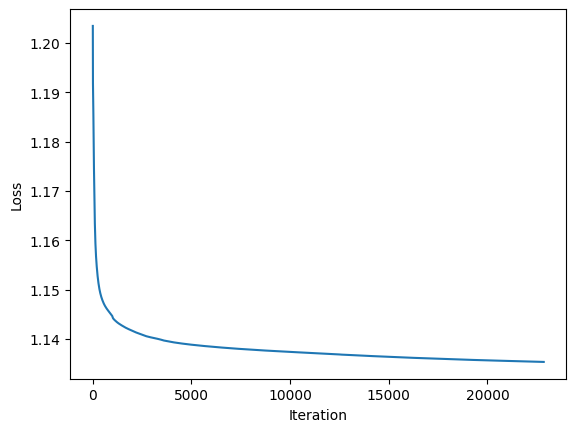

In [619]:
# Create a line plot of `losses`
plt.plot(losses)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [620]:
losses[-1]

1.135375064611435

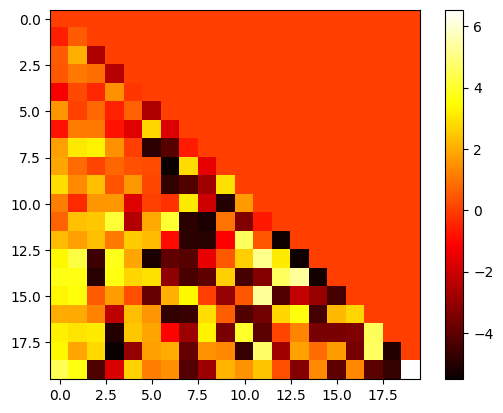

In [621]:
weight_fig=net.attention_1.part_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

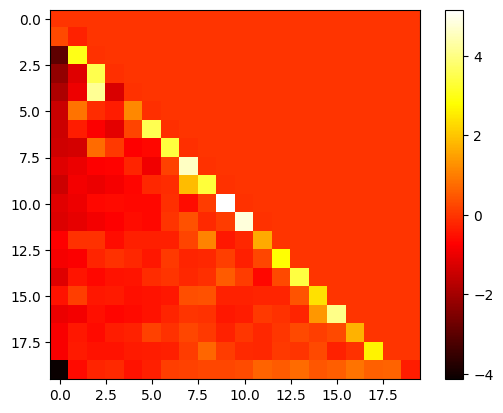

In [478]:
weight_fig=net.attention_1.part_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

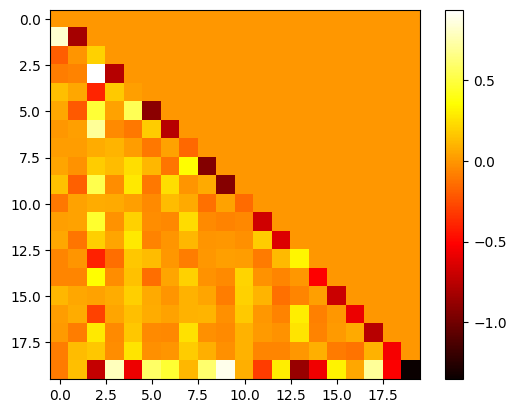

In [380]:
weight_fig=net.attention_1.part_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

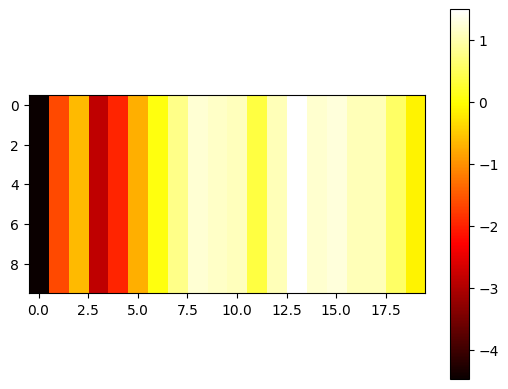

In [467]:
weight_fig=net.attention_1.part_1_2.cpu().detach().numpy()
plt.imshow(np.outer(np.ones(S),weight_fig), cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

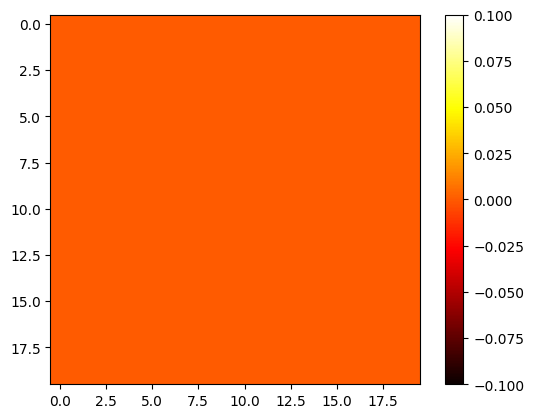

In [454]:
weight_fig=net.attention_1.sub_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

In [366]:
net.attention_1.part_1_1.cpu().detach().numpy()

array([-1.4239199], dtype=float32)

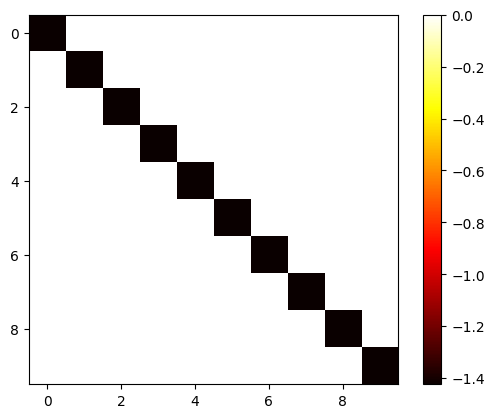

In [367]:
weight_fig=net.attention_1.part_1_1.cpu().detach().numpy()
plt.imshow(weight_fig*np.eye(S,S), cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

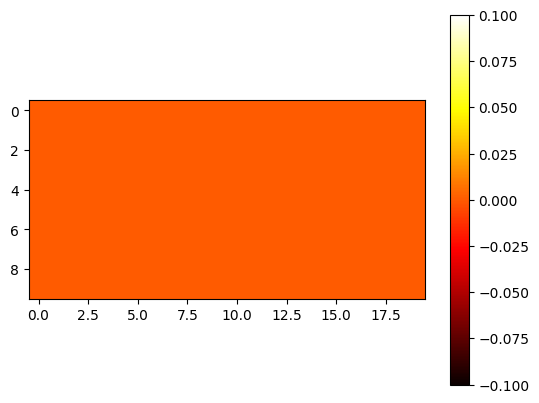

In [368]:
weight_fig=net.attention_1.part_1_2.cpu().detach().numpy()
plt.imshow(np.outer(np.ones(S),weight_fig), cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

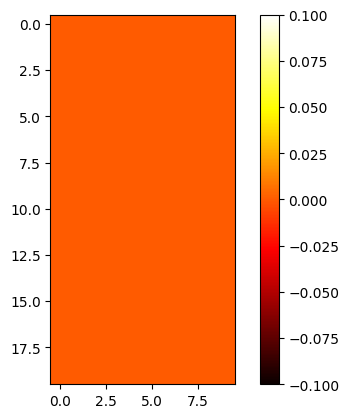

In [369]:
weight_fig=net.attention_1.part_2_1.cpu().detach().numpy()
plt.imshow(np.outer(weight_fig,np.ones(S)), cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

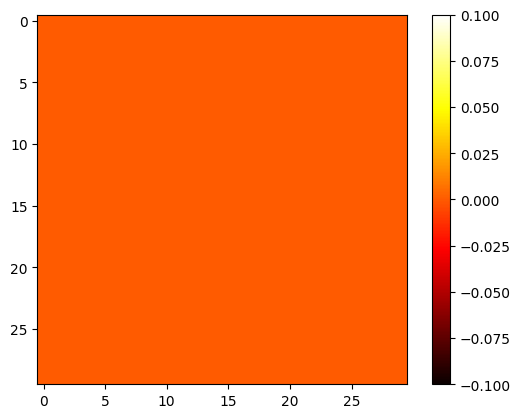

In [230]:
weight_fig=net.attention_2.part_1_1.cpu().detach().numpy()#*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

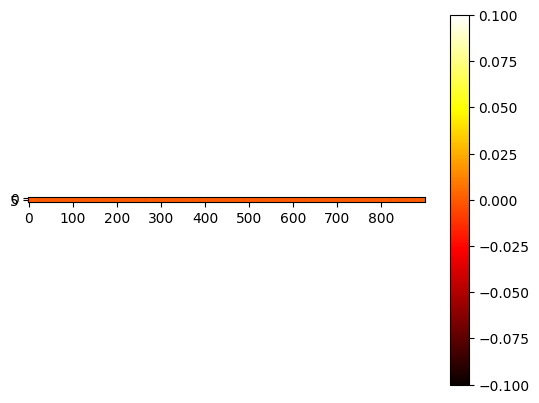

In [231]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_1_2.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

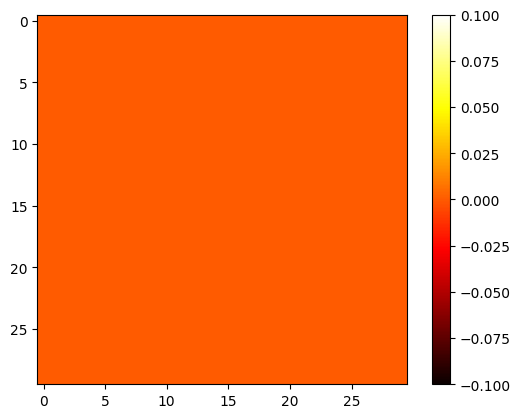

In [232]:
weight_fig=net.attention_2.part_1_3.cpu().detach().numpy()#*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

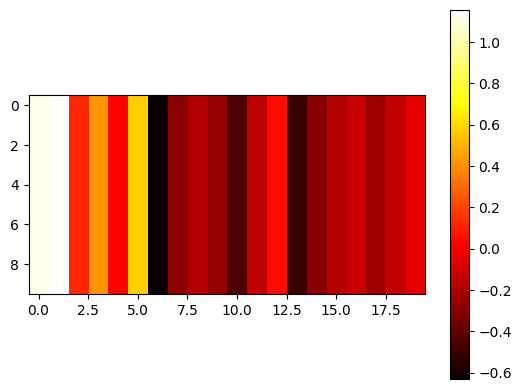

In [108]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_1_4.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

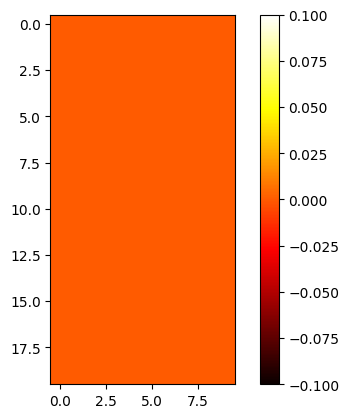

In [109]:
weight_fig=net.attention_2.part_2_1.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

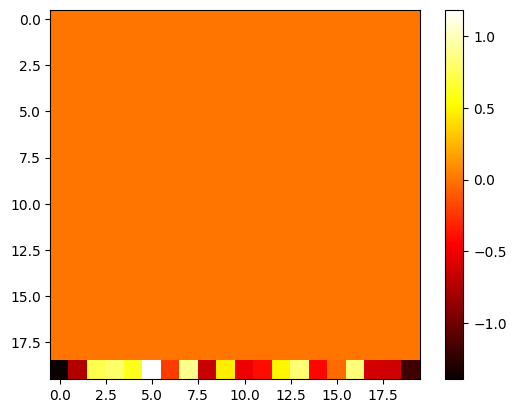

In [110]:
weight_fig=net.attention_2.part_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

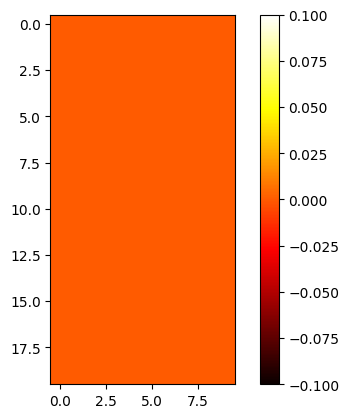

In [111]:
weight_fig=net.attention_2.part_2_3.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

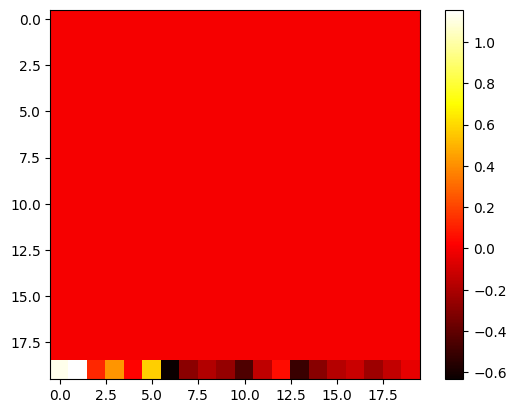

In [112]:
weight_fig=net.attention_2.part_2_4.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

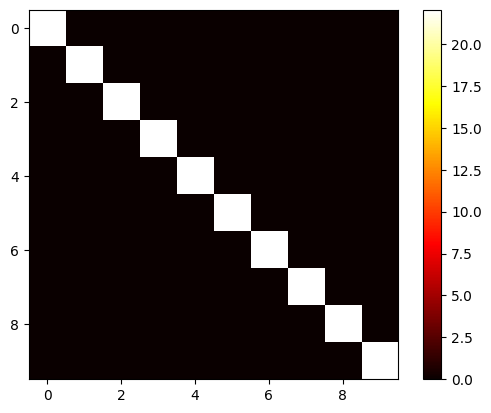

In [113]:
weight_fig=net.attention_2.part_3_1.cpu().detach().numpy()*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

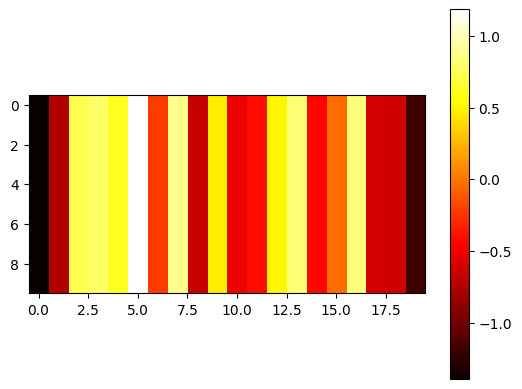

In [114]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_1_2.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

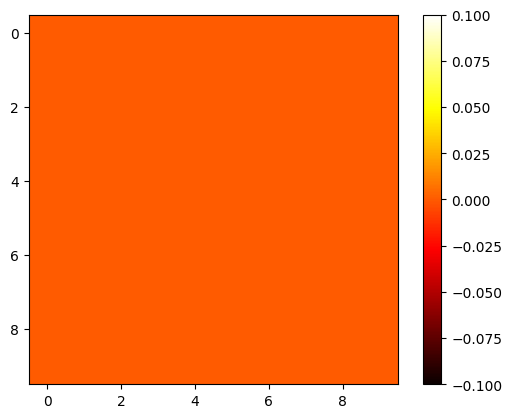

In [115]:
weight_fig=net.attention_2.part_3_3.cpu().detach().numpy()*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

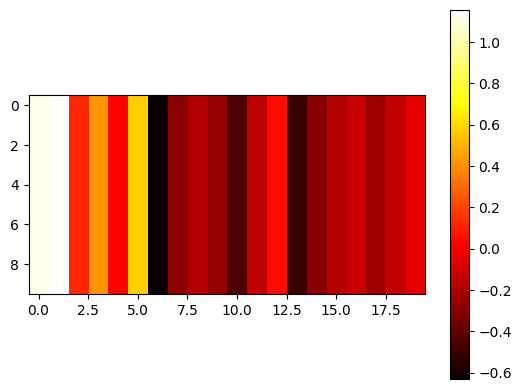

In [116]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_3_4.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

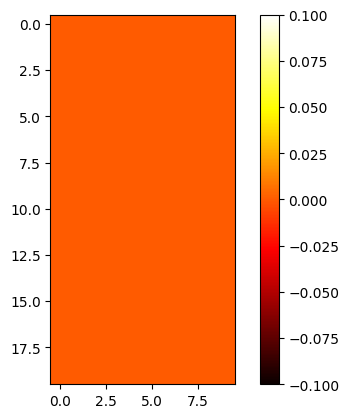

In [117]:
weight_fig=net.attention_2.part_4_1.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

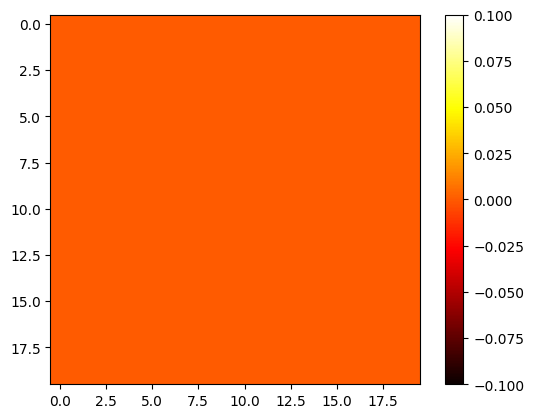

In [118]:
weight_fig=net.attention_2.part_4_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

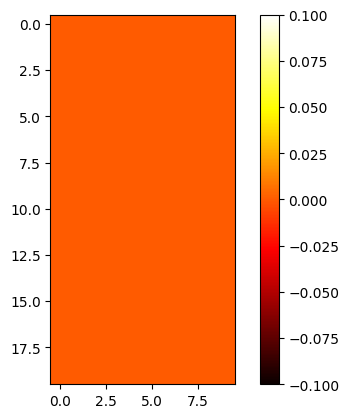

In [119]:
weight_fig=net.attention_2.part_4_3.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

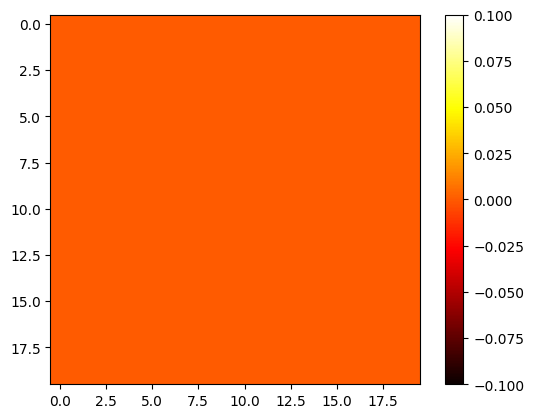

In [120]:
weight_fig=net.attention_2.part_4_4.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

In [86]:
# for j in range(20):
#     loss=np.empty(X_train_tilde.shape[0])
#     for i in range(X_train_tilde.shape[0]):
#         temp=net(X_train_tilde[i])[0][-1,:].float()+1e-6
#         loss[i]=-torch.matmul(Target_train[i],torch.log(temp))

#     Loss=sum(loss)/iter
#     print(Loss)

In [87]:
loss=np.empty(X_train_tilde.shape[0])
for i in range(X_train_tilde.shape[0]):
    temp=net(X_train_tilde[i])[0][-1,:].float()+1e-6
    loss[i]=-torch.matmul(Target_train[i],torch.log(temp))

Loss=sum(loss)/iter
print(Loss)

RuntimeError: Expected 3-dimensional tensor, but got 2-dimensional tensor for argument #1 'batch1' (while checking arguments for bmm)

Text(0, 0.5, 'Loss')

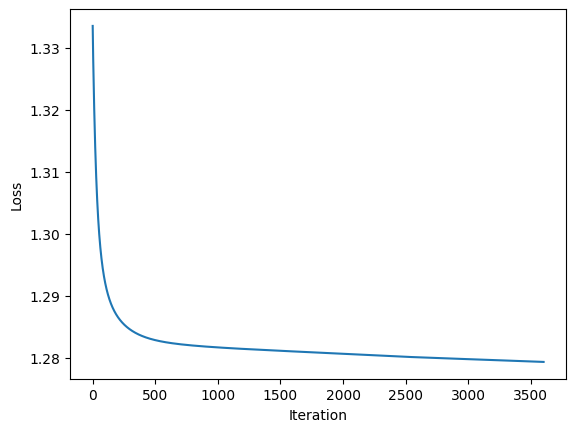

In [98]:
# Create a line plot of `losses`
plt.plot(losses)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [99]:
losses[-1]

1.279369020462036

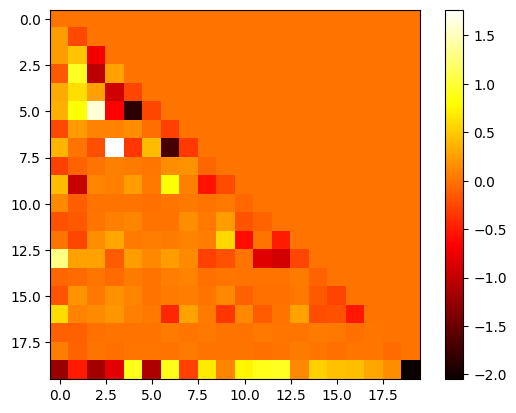

In [100]:
weight_fig=net.attention_1.part_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

In [101]:
net.attention_1.part_1_1.cpu().detach().numpy()

array([1.0286981], dtype=float32)

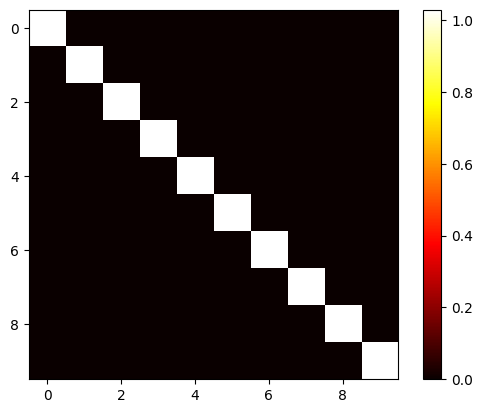

In [102]:
weight_fig=net.attention_1.part_1_1.cpu().detach().numpy()
plt.imshow(weight_fig*np.eye(S,S), cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

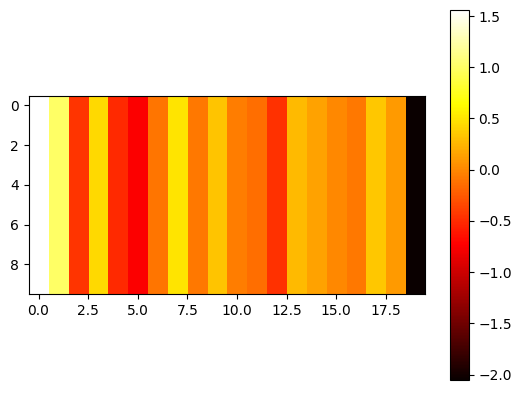

In [103]:
weight_fig=net.attention_1.part_1_2.cpu().detach().numpy()
plt.imshow(np.outer(np.ones(S),weight_fig), cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

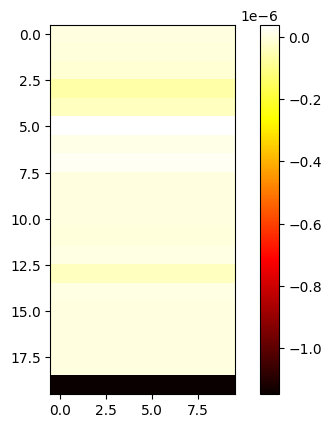

In [104]:
weight_fig=net.attention_1.part_2_1.cpu().detach().numpy()
plt.imshow(np.outer(weight_fig,np.ones(S)), cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

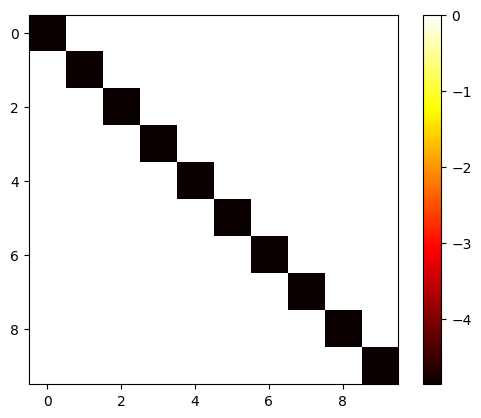

In [105]:
weight_fig=net.attention_2.part_1_1.cpu().detach().numpy()*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

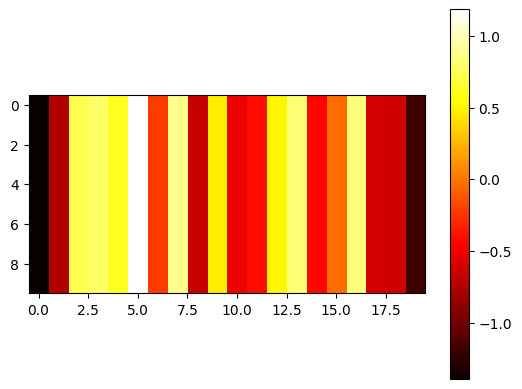

In [106]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_1_2.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

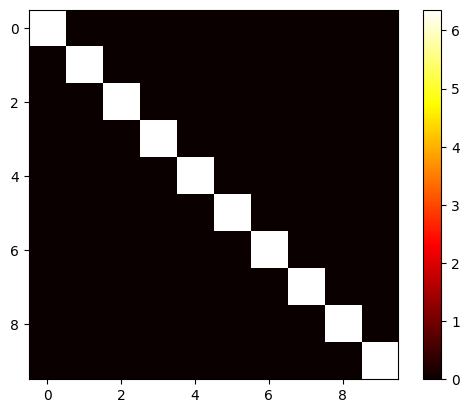

In [107]:
weight_fig=net.attention_2.part_1_3.cpu().detach().numpy()*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

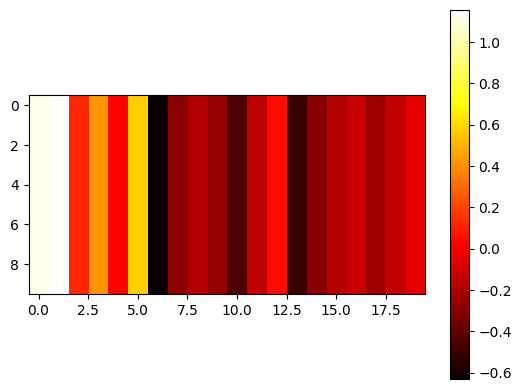

In [108]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_1_4.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

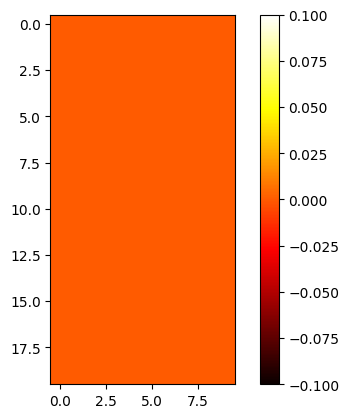

In [109]:
weight_fig=net.attention_2.part_2_1.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

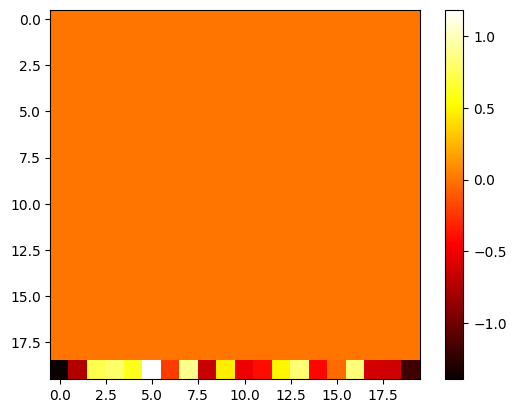

In [110]:
weight_fig=net.attention_2.part_2_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

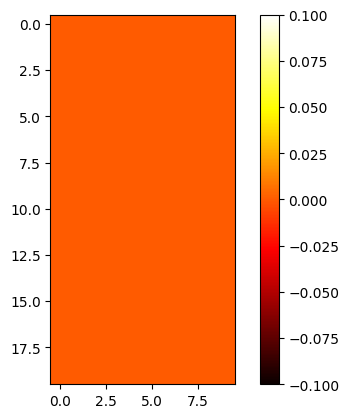

In [111]:
weight_fig=net.attention_2.part_2_3.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

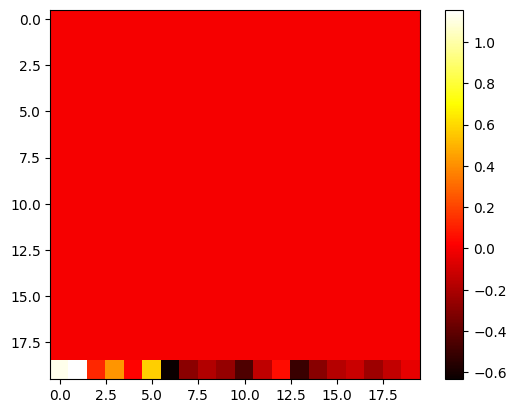

In [112]:
weight_fig=net.attention_2.part_2_4.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

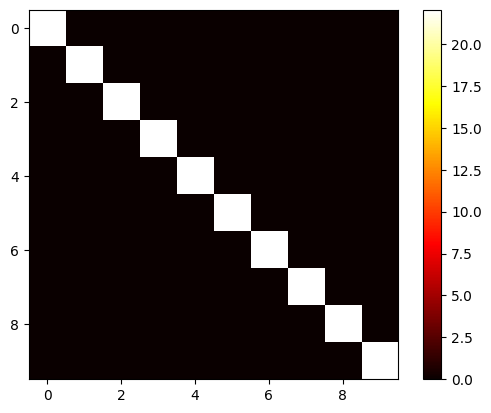

In [113]:
weight_fig=net.attention_2.part_3_1.cpu().detach().numpy()*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

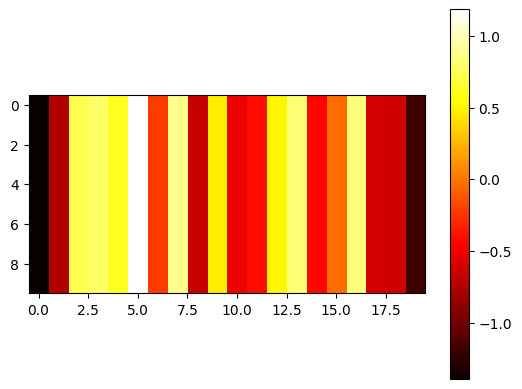

In [114]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_1_2.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

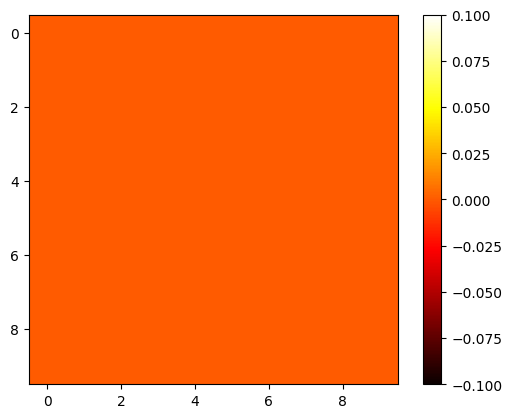

In [115]:
weight_fig=net.attention_2.part_3_3.cpu().detach().numpy()*np.eye(S)
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

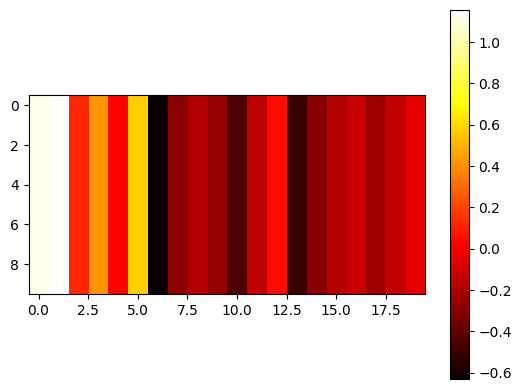

In [116]:
weight_fig=np.outer(np.ones(S),net.attention_2.part_3_4.cpu().detach().numpy())
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

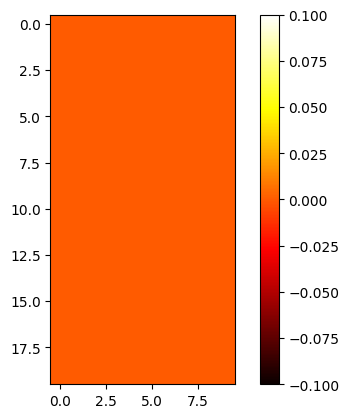

In [117]:
weight_fig=net.attention_2.part_4_1.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

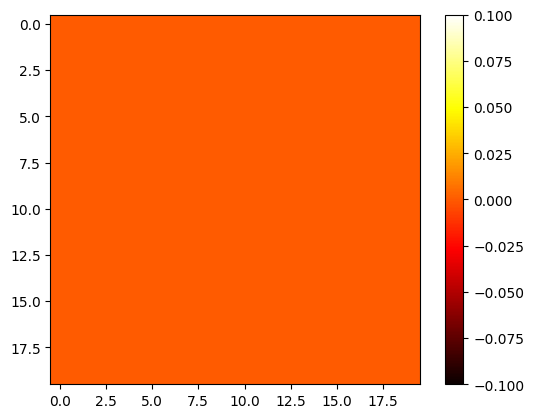

In [118]:
weight_fig=net.attention_2.part_4_2.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

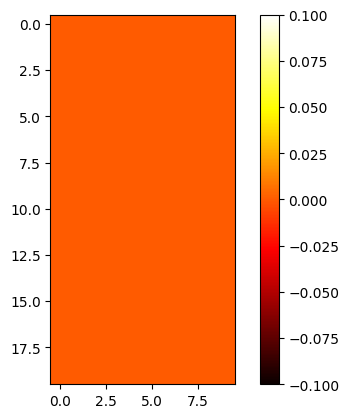

In [119]:
weight_fig=net.attention_2.part_4_3.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

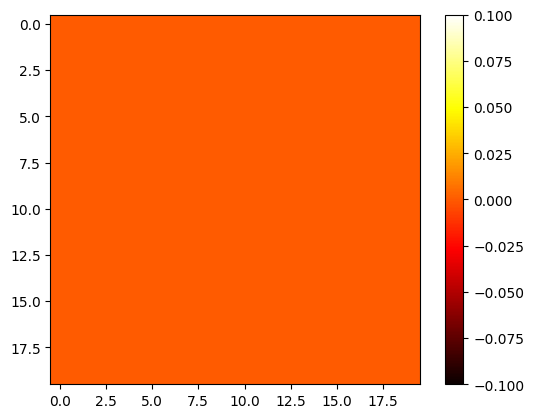

In [120]:
weight_fig=net.attention_2.part_4_4.cpu().detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

In [86]:
# for j in range(20):
#     loss=np.empty(X_train_tilde.shape[0])
#     for i in range(X_train_tilde.shape[0]):
#         temp=net(X_train_tilde[i])[0][-1,:].float()+1e-6
#         loss[i]=-torch.matmul(Target_train[i],torch.log(temp))

#     Loss=sum(loss)/iter
#     print(Loss)